ARIMA 모델 : 주식처럼 충격에 민감하고 과거의 값에도 영향을 받을 때 쓸 수 있는 모형

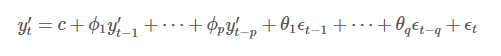

p: AR 부분의 차수
d: 차분의 정도
q: MA 부분의 차수

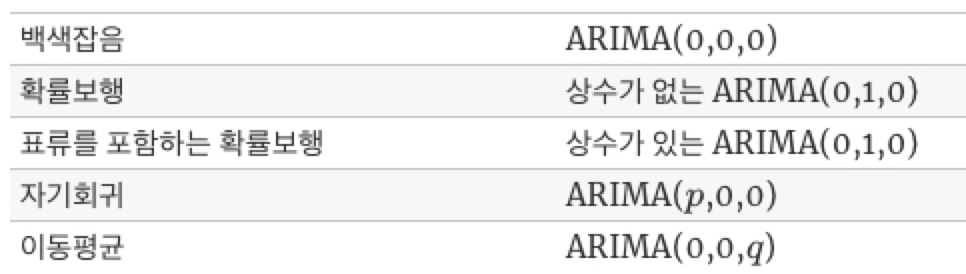



In [6]:
import os
os.getcwd()

'C:\\Users\\eunjin\\financeData'

In [7]:
path = './open'
list_name = 'Stock_List.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list.head()

,종목명,종목코드,상장시장
0,삼양홀딩스,000070,KOSPI
1,하이트진로,000080,KOSPI
2,유한양행,000100,KOSPI
3,CJ대한통운,000120,KOSPI
4,두산,000150,KOSPI


In [92]:
start_date = '2021-10-01'
end_date = '2021-11-05'
for i in stock_list['종목코드']:
    try:
        fdr.DataReader(i, start_date,start_date).iloc[0,0]
    except:
        print(stock_list[stock_list['종목코드']==i].iloc[0,0])

DL이앤씨


In [ ]:
stock_list[stock_list['종목코드']=='028150']

In [10]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

In [121]:
#한 종목 돌려보기 #예측할 날짜 : 11월 1일~5일 종료 
start_date = '2021-10-01'
end_date = '2021-11-05'

sample_code = stock_list.loc[49,'종목코드']
stock = fdr.DataReader(sample_code,start_date, end_date)
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-10-01,73900,74000,72900,73200,15803395,-0.012146
2021-10-05,73000,73000,71400,72200,24013921,-0.013661
2021-10-06,72600,72800,71200,71300,18956962,-0.012465
2021-10-07,71600,72100,71300,71600,13683532,0.004208
2021-10-08,72300,72400,71500,71500,14043287,-0.001397
2021-10-12,70700,70900,68700,69000,31001484,-0.034965
2021-10-13,68700,69600,68300,68800,24172015,-0.002899
2021-10-14,69000,69800,68800,69400,19520641,0.008721
2021-10-15,70200,71000,70000,70100,18051612,0.010086


<AxesSubplot:xlabel='Date'>

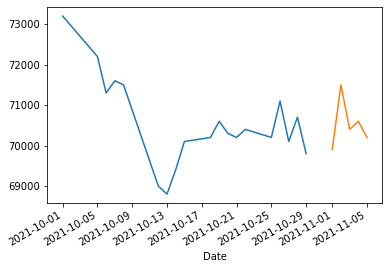

In [124]:
y_train = stock['Close'][:int(len(stock)-5)]  #train할 앞에 날짜들
y_test = stock['Close'][int(len(stock)-5):] #test할 맨 뒤 일주일( 5일 )
y_train.plot()
y_test.plot()

이전 데이터 : 계절성이나 주기성 없다고 시각화해서 확인했다.

정상성(평균이 일정, 분산이 일정, 공분산도 시차에만 의존하고 t,s 에는 의존하지 x) 만족 x -> 차분을 통해 정상화

*차분 : 현시점 자료에서 전 시점 자료 빼는 것)
*분산이 일정하지 않을 경우 변환 필요

In [125]:
#차분이 필요한지, 몇 차 차분이 최선인지 파악하려면 ndiff 함수 이용
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 2


In [126]:
model = pm.auto_arima(y = y_train        # array형태 시계열 자료
                      , d = n_diffs          # 차분 차수, ndiffs 결과!
                      , start_p = 0 #AR(p)찾을 범위 0~3
                      , max_p = 3   
                      , start_q = 0 #AR(q) 찾을 범위 0~3
                      , max_q = 3   
                      , m = 1       #계절적 차분? -> X 4면 분기별 12면 월별임.
                      , seasonal = False # 계절성 ARIMA가 아니라서.
                      , stepwise = True #최적의 모수를 찾기 위해 힌드만-칸다카르 알고리즘을 사용할지? false면 모든 모수 조합
                      , trace=True #stepwise모델 적합할 때 마다 결과 프린트
                      )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=293.089, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=295.489, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=294.946, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=291.091, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=302.805, Time=0.05 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.145 seconds


In [ ]:
#ARIM (0,1,0) 모델로 나옴 2차 차분했을 때 백색잡음임 (N (0, sigma^2))

In [127]:
#잔차검정
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -144.545
Date:                Tue, 22 Mar 2022   AIC                            291.091
Time:                        19:32:15   BIC                            291.924
Sample:                             0   HQIC                           291.173
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.409e+06   5.31e+05      2.652      0.008    3.68e+05    2.45e+06
Ljung-Box (L1) (Q):                   4.67   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.03   Pr

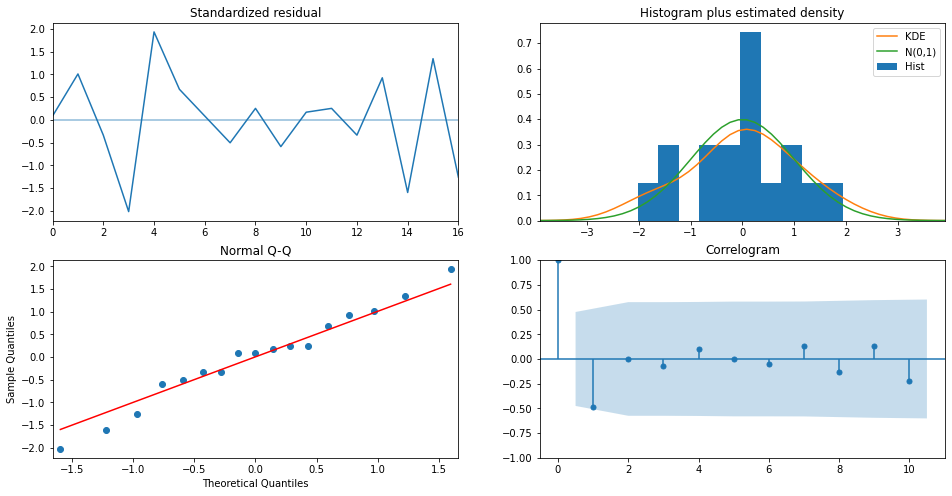

In [128]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

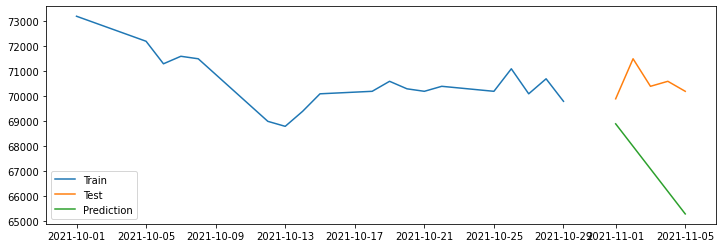

In [129]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [130]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [131]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !
    model.update(new_ob)

In [132]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2021-11-01,69900,68900.0
2021-11-02,71500,70000.0
2021-11-03,70400,73100.0
2021-11-04,70600,69300.0
2021-11-05,70200,70800.0


In [133]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -188.834
Date:                Tue, 22 Mar 2022   AIC                            379.669
Time:                        19:32:30   BIC                            380.760
Sample:                             0   HQIC                           379.926
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.669e+06   5.84e+05      2.857      0.004    5.24e+05    2.81e+06
Ljung-Box (L1) (Q):                   7.44   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.01   Pr

In [134]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,2,0)모형")
fig.show()

In [135]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")
print(f"평가 산식 NMAE*100: {NMAE(y_test, y_pred)*100: .3f}")

MAPE: 2.012
평가 산식 NMAE*100:  2.012


In [120]:
# SARIMAX 모델링 적합 모델 찾는 코드? 아직 수정X
## Additional Features
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
## Parameter Setting
p, q = range(1,3), range(1,3)
d = range(0,1)
P, Q = range(1,3), range(1,3)
D = range(1,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]
## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
        try:
            result =sm.tsa.SARIMAX(Y_train_feR, trend='c', 
                                   order=trend_param, seasonal_order=seasonal_params, exog=exog_tr).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0],
                                                             SARIMAX_order[AIC.index(min(AIC))][1]))

NameError: name 'X_train_feRSM' is not defined